In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


In [0]:
import os
import cv2
import numpy as np

In [4]:
!pip install medpy
from keras.layers import *
import keras
from keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from medpy.metric import dc, precision, recall
from keras import Model

     |████████████████████████████████| 153kB 6.5MB/s 
     |████████████████████████████████| 42.5MB 78kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753428 sha256=dd14131208744fe487454daf227d295cc2660c365aa26fb1f94287b2b722c269
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy


Using TensorFlow backend.


In [0]:
PATH = "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays"

Train = ['263','232','239','252']
Test  = ['242', '229','230','221','246']

# Train set patients: 232 263 239 252 

TrainX_1 = np.load(PATH + '/4 Class PR/PR IHC 263 Images.npy')
TrainY_1 = np.load(PATH + '/Negative Masks/PR IHC 263.npy')
TrainX_2 = np.load(PATH + '/4 Class PR/PR IHC 232 Images.npy')
TrainY_2 = np.load(PATH + '/Negative Masks/PR IHC 232.npy')
TrainX_3 = np.load(PATH + '/4 Class PR/PR IHC 239 Images.npy')
TrainY_3 = np.load(PATH + '/Negative Masks/PR IHC 239.npy')
TrainX_4 = np.load(PATH + '/4 Class PR/PR IHC 252 Images.npy')
TrainY_4 = np.load(PATH + '/Negative Masks/PR IHC 252.npy')

# Test set patients: 242 229  230 221 246
TestX_1 = np.load(PATH + '/4 Class PR/PR IHC 242 Images.npy')
TestY_1 = np.load(PATH + '/Negative Masks/PR IHC 242.npy')
TestX_2 = np.load(PATH + '/4 Class PR/PR IHC 229 Images.npy')
TestY_2 = np.load(PATH + '/Negative Masks/PR IHC 229.npy')
TestX_3 = np.load(PATH + '/4 Class PR/PR IHC 230 Images.npy')
TestX_4 = np.load(PATH + '/4 Class PR/PR IHC 221 Images.npy')
TestX_5 = np.load(PATH + '/4 Class PR/PR IHC 246 Images.npy')

In [33]:
TrainX = np.concatenate((TrainX_1, TrainX_2, TrainX_3, TrainX_4), axis=0)
TrainY = np.concatenate((TrainY_1, TrainY_2, TrainY_3, TrainY_4), axis=0)

TrainY[TrainY==255] = 1
TrainY = keras.utils.to_categorical(TrainY, num_classes=2)

TestX = np.concatenate((TestX_1,TestX_2,TestX_3,TestX_4,TestX_5), axis=0)
TestY = np.concatenate((TestY_1,TestY_2), axis=0)

TestY[TestY==255] = 1
TestY = keras.utils.to_categorical(TestY, num_classes=2)

ValidX = TrainX[1800:, : ]
ValidY = TrainY[1800:, : ]

TrainX = TrainX[0:1800, : ]
TrainY = TrainY[0:1800, : ]

print(TrainX.shape)
print(TrainY.shape)
print(TestX.shape)
print(TestY.shape)
print(ValidX.shape)
print(ValidY.shape)

(1800, 240, 240, 3)
(1800, 240, 240, 2)
(2592, 240, 240, 3)
(960, 240, 240, 2)
(120, 240, 240, 3)
(120, 240, 240, 2)


In [0]:
TrainX = np.reshape(TrainX,(-1,240, 240,3))
TrainY = np.reshape(TrainY,(-1,240, 240,2))

TrainX = TrainX.astype('float32')/255

TestX = np.reshape(TestX,(-1,240, 240,3))
TestY = np.reshape(TestY,(-1,240, 240,2))

TestX = TestX.astype('float32')/255

ValidX = np.reshape(ValidX,(-1,240, 240,3))
ValidY = np.reshape(ValidY,(-1,240, 240,2))

ValidX = ValidX.astype('float32')/255

In [35]:
print(TrainX.shape)
print(TrainY.shape)

print(TestX.shape)
print(TestY.shape)

print(ValidX.shape)
print(ValidY.shape)

(1800, 240, 240, 3)
(1800, 240, 240, 2)
(2592, 240, 240, 3)
(960, 240, 240, 2)
(120, 240, 240, 3)
(120, 240, 240, 2)


In [0]:
def get_conv_block(input_layer,nFilters,size):
    conv1 = Conv2D(nFilters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
    bn1 = BatchNormalization()(conv1)
    conv2 = Conv2D(nFilters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn1)
    bn2 = BatchNormalization()(conv2)
    return bn2
    
def get_model():    
    input_layer = Input(shape=(240,240,3))
    block1 = get_conv_block(input_layer,32,3)
    mp1 = MaxPooling2D(pool_size=(2, 2))(block1)
    dr1 = Dropout(0.1)(mp1)
    
    block2 = get_conv_block(dr1,64,3)
    mp2 = MaxPooling2D(pool_size=(2, 2))(block2)
    dr2 = Dropout(0.1)(mp2)
    
    block3 = get_conv_block(dr2,128,3)
    mp3 = MaxPooling2D(pool_size=(2, 2))(block3)
    dr3 = Dropout(0.1)(mp3)
    
    block4 = get_conv_block(dr3,256,3)
    mp4 = MaxPooling2D(pool_size=(2, 2))(block4)
    dr4 = Dropout(0.1)(mp4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(dr4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up1 = Conv2DTranspose(256,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(conv5)
    cat1 = concatenate([block4,up1])
    dr1 = Dropout(0.1)(cat1)
    block5 = get_conv_block(dr1,256,3)

    up2 = Conv2DTranspose(128,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block5)
    cat2 = concatenate([block3,up2])
    dr2 = Dropout(0.1)(cat2)
    block6 = get_conv_block(dr2,128,3)
    
    up3 = Conv2DTranspose(64,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block6)
    cat3 = concatenate([block2,up3])
    dr3 = Dropout(0.1)(cat3)
    block7 = get_conv_block(dr3,64,3)
    
    up4 = Conv2DTranspose(32,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block7)
    cat4 = concatenate([block1,up4])
    dr4 = Dropout(0.1)(cat4)
    block8 = get_conv_block(dr4,64,3)

    # conv10 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(block8)
    conv11 = Conv2D(2,(1,1), activation='softmax', padding = 'same')(block8)

    model = Model(input_layer,conv11)
    return model

In [12]:
model = get_model()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 240, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 32) 9248        batch_normalization_1[0][0]      
__________

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

In [0]:
import math
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
mc = ModelCheckpoint('Checkpoint.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [0]:
optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.001, decay=0.0, amsgrad=True)

In [0]:
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def combined_loss(y_true, y_pred):
  return (1*K.categorical_crossentropy(y_true, y_pred))+(1*tversky_loss(y_true, y_pred))

In [0]:
from keras import backend as K      
model.compile(loss=combined_loss, optimizer=optimizer, metrics=[dice_coef,'accuracy'])

In [0]:
num_epoch = 100;
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models"
history = model.fit(TrainX, TrainY, epochs=num_epoch, validation_data=(ValidX, ValidY), shuffle=True,batch_size=16,callbacks=[es,mc])
model.save(MODELS_PATH + '/PR_Negative_21_04_20.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1800 samples, validate on 120 samples
Epoch 1/100
1800/1800 [==============================] - 123s 68ms/step - loss: 0.7353 - dice_coef: 0.8791 - accuracy: 0.9203 - val_loss: 1.6591 - val_dice_coef: 0.8442 - val_accuracy: 0.8477

Epoch 00001: val_loss improved from inf to 1.65914, saving model to Checkpoint.h5
Epoch 2/100
1800/1800 [==============================] - 110s 61ms/step - loss: 0.4610 - dice_coef: 0.9295 - accuracy: 0.9443 - val_loss: 0.9341 - val_dice_coef: 0.8965 - val_accuracy: 0.8988

Epoch 00002: val_loss improved from 1.65914 to 0.93406, saving model to Checkpoint.h5
Epoch 3/100
1800/1800 [==============================] - 110s 61ms/step - loss: 0.4211 - dice_coef: 0.9362 - accuracy: 0.9474 - val_loss: 0.5498 - val_dice_coef: 0.9288 - val_accuracy: 0.9317

Epoch 00003: val_loss improved from 0.93406 to 0.54985, saving model to Checkpoint.h5
Epoch 4/100
1800/1800 [==

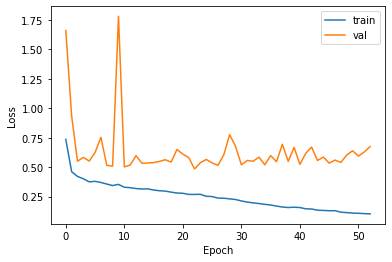

In [0]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
xc=range(len(train_loss))
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

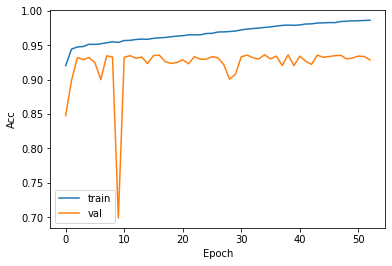

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

In [18]:
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models"
model = keras.models.load_model(MODELS_PATH+ '/PR_Negative_21_04_20.h5',custom_objects={ 'combined_loss': combined_loss, 'dice_coef': dice_coef })

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [19]:
TrainX = np.concatenate((TrainX,ValidX))
TrainY = np.concatenate((TrainY,ValidY))
train_result = model.predict(TrainX, batch_size=16)
Train_predict = np.argmax(train_result,axis=3)
Train_predict[Train_predict==1] = 255

print(np.shape(train_result))
print(Train_predict.shape)

(1920, 240, 240, 2)
(1920, 240, 240)


In [36]:
test_result = model.predict(TestX, batch_size=16)
Test_predict = np.argmax(test_result,axis=3)
Test_predict[Test_predict==1] = 255

print(np.shape(test_result))
print(Test_predict.shape)

(2592, 240, 240, 2)
(2592, 240, 240)


In [0]:
def stitchMaskPatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240] = pieces[k]
      k = k + 1
  return reconstructed_img


def stitchImagePatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920,3])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240,:] = pieces[k]
      k = k + 1
  return reconstructed_img


In [0]:
def saveNumpyOutput(mask, Patient_array,Patient_length,title):
  idx = 0
  for i in range(len(Patient_length)):
    temp = []
    for j in range(Patient_length[i]):
      final_output = mask[idx:idx+48]
      idx = idx + 48
      final_output = stitchMaskPatches(final_output)
      temp.append(final_output)
    final_output = np.asarray(temp)
    np.save("/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/Predicted Output/Negative/PR/" + title + Patient_array[i], final_output)
    print(Patient_array[i])

In [38]:
Train = ['263','232','239','252']
Test  = ['242', '229','230','221','246']
Train_len = [10,10,10,10]
Test_len = [10,10,14,10,10]

# saveNumpyOutput(Train_predict, Train, Train_len,"Train/")
saveNumpyOutput(Test_predict, Test, Test_len,"Test/")

242
229
230
221
246


(1440, 1920, 3)
(1440, 1920)
(1440, 1920)


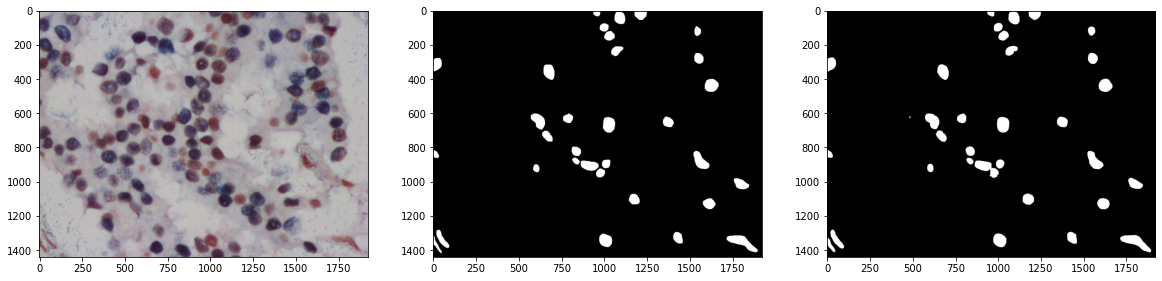

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 2  # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TrainX[id:id+48]

Mask_input = np.argmax(TrainY[id:id+48],axis=3)
Mask_input[Mask_input == 1] = 255

final_output = Train_predict[id:id+48]
final_output[final_output==1] = 255

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

# # print(np.unique(final_output))
# copy1  = np.copy(final_input)
# copy2 = copy1.astype('float64')*255
# copy2 = copy2.astype('uint8')
# final_input = np.reshape(final_input,(1440, 1920,3))
# final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')


(1440, 1920, 3)
(1440, 1920)
(1440, 1920)


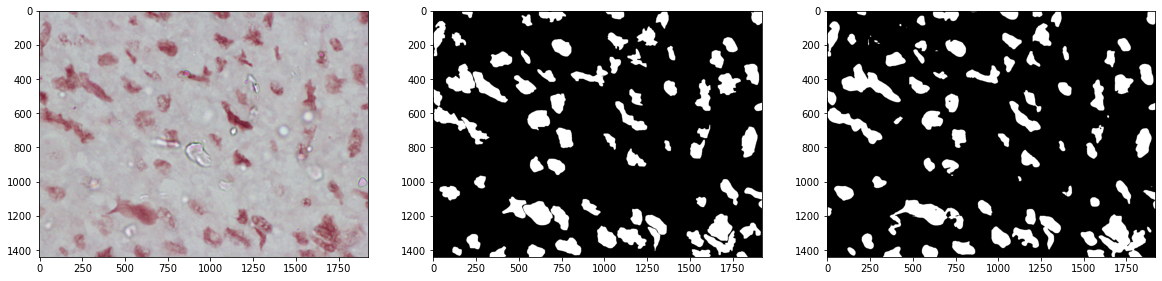

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 10  # enter between 0- 19 since there are 2 patients with 10 images each

id = id * 48
final_input = TestX[id:id+48]

Mask_input = np.argmax(TestY[id:id+48],axis=3)
Mask_input[Mask_input == 1] = 255

final_output = Test_predict[id:id+48]
final_output[final_output==1] = 255

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

# print(np.unique(final_output))
# copy1  = np.copy(final_input)
# copy2 = copy1.astype('float32')*255
# copy2 = copy2.astype('uint8')
# final_input = np.reshape(copy2,(1440, 1920,3))
# final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')
